# Opertor mappings
Here's an attempt to create single-state operators that reflect rotations and such. This can done with the lattice object. 

The idea is to have a mapping of bits in the inital state to bits in the final state which relect the operator in question. This is essentially realized as a list of index, a sort of "permutation" if you want, that reflects the desired operation.

In [1]:
import numpy as np
import sys

sys.path.append('../symmetry_stuff/')
from lattice_object import LatticeObject

Setting up lattice 4096
|000000000001000000000000> (4096)
# of flippable plaquettes: 0
|000000001000000000000000> (32768)
# of flippable plaquettes: 0


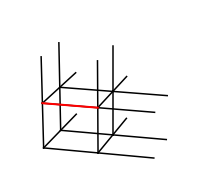

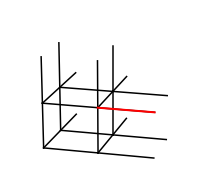

In [12]:
ji = 13
state = LatticeObject(1<<ji-1, L=[2,2,2])
print(state.to_bin())
state.draw()
state.apply_alternate_parity_flip()
print(state.to_bin())
state.draw()

### Create the parity map.

In [8]:
def make_op_map(L, op):
    n_spins = np.prod(L)*len(L)
    op_map = np.zeros(shape=(n_spins), dtype=int)

    for i in range(n_spins):
        latt = LatticeObject(1<<i, L=L, quiet=True)
        op(latt)
        for j in range(n_spins):
            temp = latt.to_int()
            if (temp >> j)&1:
                op_map[i] = int(j)
                break
                
    return op_map

op_map = make_op_map([2,2,2], lambda x: x.apply_parity_flip())
op_map

array([21, 22, 23, 18, 19, 20, 15, 16, 17, 12, 13, 14,  9, 10, 11,  6,  7,
        8,  3,  4,  5,  0,  1,  2])

In [9]:
state = LatticeObject(1232342, L=[2,2,2], quiet=True)
state_arr = np.array([int(s) for s in state.to_bin()[1:25]])
print("initial state bits: ", state_arr)

final_state_arr = np.array([state_arr[k] for k in op_map])
print("final state bits:   ", final_state_arr)

final_state = sum([final_state_arr[-i-1]<<i for i in range(24)])
print("integer mapping: {:d} --> {:d}".format(state.to_int(), final_state))

initial state bits:  [0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0]
final state bits:    [1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0]
integer mapping: 1232342 --> 13363552


## Batch processing and creation of a YAML file.

In [10]:
lattices = [
    [2,2,2],
    [2,2,4],
    [2,2,6]
]
operators = {
    "parity" : lambda x: x.apply_alternate_parity_flip(),
    "unity" : lambda x: x
}

op_maps = {}
for L in lattices:
    latt_op_map = {}
    for name, op in operators.items():
        # Attention: we need a +1 here because Julia is 1-based in the indicies.
        latt_op_map[name] = (make_op_map(L, op)+1).tolist()
    op_maps["x".join(map(str, L))] = latt_op_map

# op_maps

#### Store Operator maps
This can conveniently done with YAML, simply dump the file so that we can read the dictionary later with Julia.

In [174]:
import yaml

with open("../julia_gl/src/operators/operator_masks.yml", "w") as file:
      file.write(yaml.dump(op_maps, default_flow_style=False))

## Dump as jl sourcecode.

This is the Julia format we would need.
```
make_operators() = Dict(
 "2x2x2" => Dict("parity" => [1,2,3])
)
```

Note, that this will actually be a piece of the source code. 

In [11]:
import datetime, time, socket

with open("../julia_gl/src/operators/gl_operators.jl", "w+") as file:
    file.write("# [Automatically generated @{:s} at {:s}]\n".format(
        socket.gethostname(),
        datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
    )
    file.write('include("../typedefs.jl")\n\n')
    file.write("gl_operators = Dict(\n")
    for latt, latt_ops in op_maps.items():
        file.write('    "{:s}" => Dict(\n'.format(latt))
        for name, op_map in latt_ops.items():
            file.write('        "{:s}" => Operator("{:s}", [{:s}]),\n'.format(name, name, ", ".join(map(str,op_map))))
        file.write("    ),\n")
    file.write(")\n")